# Explainable AI (XAI): Global Methods

**Author:** Martin Beneš

This is a preparatory notebook for demo in global methods in XAI for course 703326: Advanced Machine Learning.

Here the tested PyTorch network is trained.

In [1]:
import glob
import matplotlib.pyplot as plt
import PIL.Image
import torch
import torchvision
import typing

The task is to distinguish cats and dogs.

## Cat-Dog Dataset

We start by loading the dataset with images of cats and dogs.

In [2]:
class CatDogDataset(torch.utils.data.Dataset):
    """Class representing the Cat-Dog dataset."""
    def __init__(self, image_paths, transform=None, debug=False):
        """Constructor."""
        super().__init__()
        self.paths = image_paths
        self.transform = transform
        self.debug = debug
    
    def __len__(self) -> int:
        """Dataset size."""
        return len(self.paths)
    
    def __getitem__(self, index: int) -> typing.Tuple[torch.tensor, int]:
        """Indexing dataset."""
        path = self.paths[index]
        label = int('dog' in path.split('/')[-1])  # dog 1, cat 0
        if self.debug:
            return (path, label)
        image = PIL.Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return (image, label)

We run similar code for loading train and validation datasets. Note that train dataset contains training-time augmentations, such as random flipping and rotations.

In [3]:
# training set
tr_files = glob.glob('cats_and_dogs/train/*/*')
tr_dataset = CatDogDataset(
    tr_files,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize((128, 128)),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation(20),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,))
    ])
)
tr_dataloader = torch.utils.data.DataLoader(
    tr_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True)

Validation dataset only resizes and normalizes. Test-time augmentation (TTA) is not used.

In [4]:
# validation set
va_files = glob.glob('cats_and_dogs/validation/*/*')
va_dataset = CatDogDataset(
    va_files,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize((128, 128)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,))
    ])
)
va_dataloader = torch.utils.data.DataLoader(
    va_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True)

## ResNet18-based Model

For our model, we transfer ResNet18 model, pretrained on ImageNet. We need to fine-tune to our dataset.

Thus, we freeze all the layers except last, fully connected.

In [5]:
# get ResNet model
model_resnet18 = torchvision.models.get_model('resnet18', pretrained=True)
# freeze model weights
for name, param in model_resnet18.named_parameters():
    if("bn" not in name):
        param.requires_grad = False

# add trainable FC layer
model_resnet18.fc = torch.nn.Sequential(
    torch.nn.Linear(model_resnet18.fc.in_features,512),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(512, 2)
)

# move to device
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu') 
model_resnet18 = model_resnet18.to(device)

/home/martin.benes/.ml/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/martin.benes/.ml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training

First, we separately train FC layer only. Then the whole network is fine-tuned with very low learning rate.

In [6]:
# training parameters
epochs = 30
loss_fn = torch.nn.CrossEntropyLoss()

# first train FC, then fine-tune network
for lr in [1e-3, 1e-5]:
    optimizer = torch.optim.Adam(model_resnet18.parameters(), lr=lr)

    # iterate epochs
    for epoch in range(epochs):
        training_loss, valid_loss = 0., 0.
        model_resnet18.train()
    
        # iterate training batches
        for batch in tr_dataloader:
            inputs, targets = map(lambda i: i.to(device), batch)
        
            # zero gradients
            optimizer.zero_grad()

            # forward-pass
            outputs = model_resnet18(inputs)
            loss = loss_fn(outputs, targets)
        
            # backward-pass
            loss.backward()
            optimizer.step()
        
            # score
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(tr_dataloader.dataset)
    
        # evaluate validation batches
        model_resnet18.eval()
        correct, total = 0, 0
        for batch in va_dataloader:
            inputs, targets = map(lambda i: i.to(device), batch)
        
            # forward-pass
            outputs = model_resnet18(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = loss_fn(outputs, targets) 
        
            # score
            valid_loss += loss.data.item() * inputs.size(0)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
        valid_loss /= len(va_dataloader.dataset)
    
        # log
        print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}, accuracy = {:.4f}'.format(epoch, training_loss,
            valid_loss, correct / total))
        
    # unfreeze layers
    for name, param in model_resnet18.named_parameters():
        if("bn" not in name):
            param.requires_grad = True

Epoch: 0, Training Loss: 0.4664, Validation Loss: 0.1972, accuracy = 0.9210
Epoch: 1, Training Loss: 0.3280, Validation Loss: 0.1694, accuracy = 0.9270
Epoch: 2, Training Loss: 0.2923, Validation Loss: 0.1555, accuracy = 0.9270
Epoch: 3, Training Loss: 0.2599, Validation Loss: 0.1442, accuracy = 0.9290
Epoch: 4, Training Loss: 0.2440, Validation Loss: 0.1870, accuracy = 0.9270
Epoch: 5, Training Loss: 0.2281, Validation Loss: 0.1507, accuracy = 0.9460
Epoch: 6, Training Loss: 0.2375, Validation Loss: 0.1510, accuracy = 0.9360
Epoch: 7, Training Loss: 0.2300, Validation Loss: 0.1343, accuracy = 0.9440
Epoch: 8, Training Loss: 0.2071, Validation Loss: 0.1456, accuracy = 0.9300
Epoch: 9, Training Loss: 0.1725, Validation Loss: 0.1388, accuracy = 0.9470
Epoch: 10, Training Loss: 0.1727, Validation Loss: 0.1338, accuracy = 0.9440
Epoch: 11, Training Loss: 0.1873, Validation Loss: 0.1252, accuracy = 0.9490
Epoch: 12, Training Loss: 0.1741, Validation Loss: 0.1384, accuracy = 0.9460
Epoch: 13

## Evaluate

We evaluate the model performance on the validation dataset.

In [7]:
# compute model accuracy
correct, total = 0, 0
with torch.no_grad():
    
    # iterate validation batches
    for batch in va_dataloader:
        inputs, targets = map(lambda i: i.to(device), batch)
        
        # forward-pass
        outputs = model_resnet18(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        # score
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

# compute and print
print('correct: {:d}  total: {:d}'.format(correct, total))
print('accuracy = {:f}'.format(correct / total))

correct: 956  total: 1000
accuracy = 0.956000


Accuracy is 95.6%.

For illustration, we show 10 random cases of cats and dogs and their prediction.

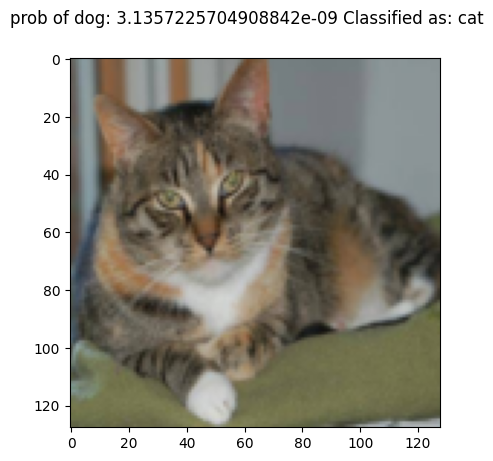

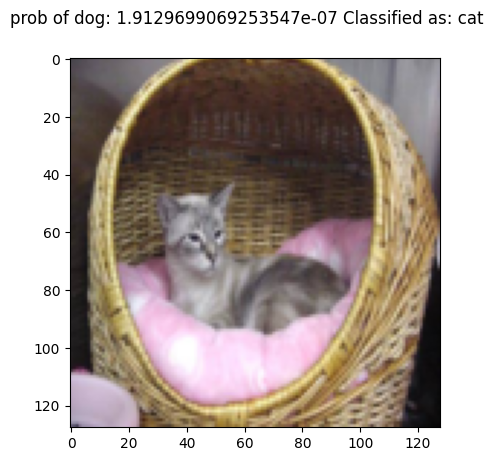

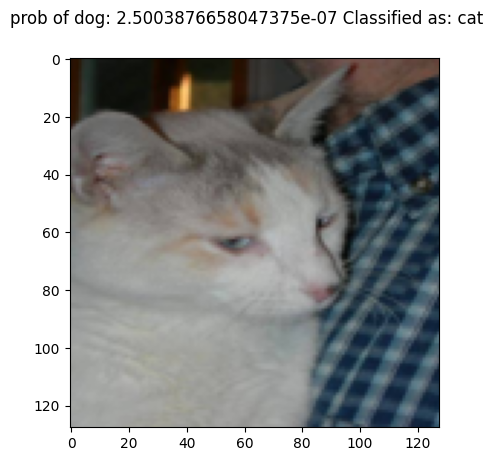

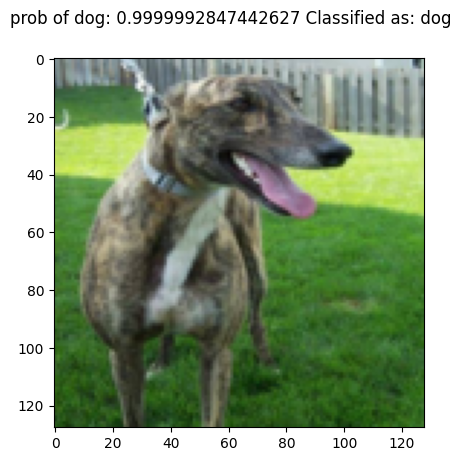

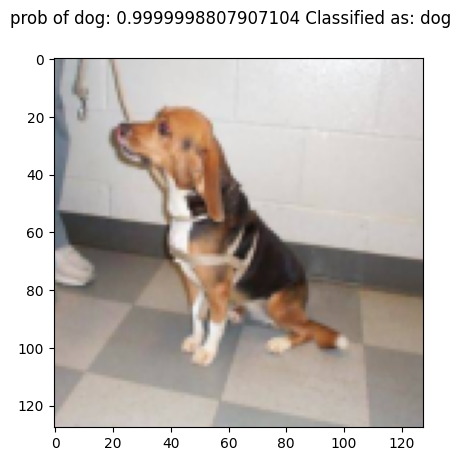

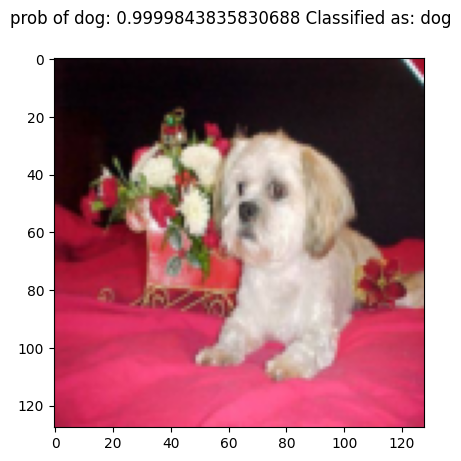

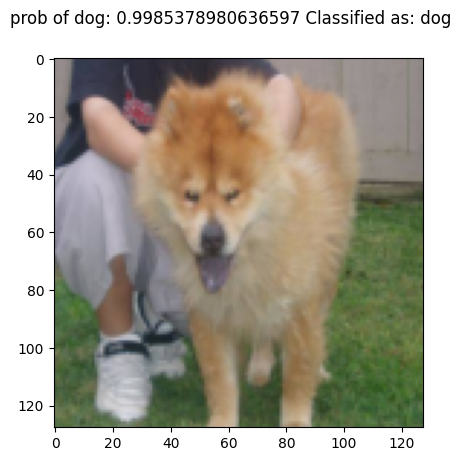

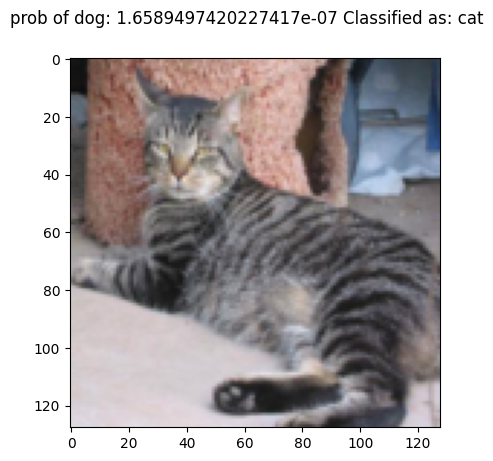

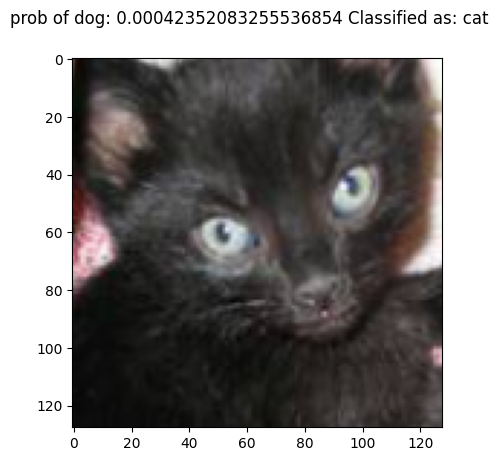

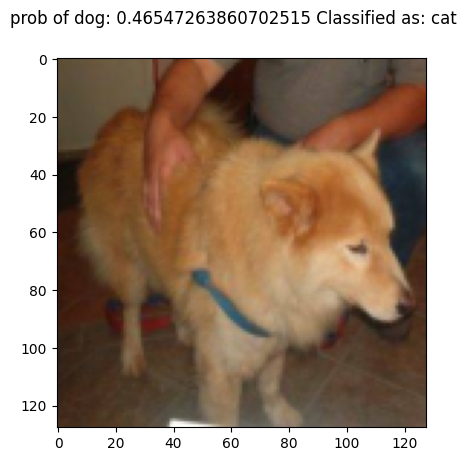

In [8]:
# prediction of 10 random images
batch_size = 10
correct, total = 0, 0
with torch.no_grad():
    
    # choose the images
    g = torch.Generator()
    g.manual_seed(42)
    subset_dataset = torch.utils.data.RandomSampler(va_dataset, num_samples=batch_size, generator=g)
    for batch in torch.utils.data.BatchSampler(subset_dataset, batch_size=batch_size, drop_last=True):
        
        # parse images
        images = [va_dataset[idx][0] for idx in batch]
        labels = [va_dataset[idx][1] for idx in batch]
        images = torch.stack(images)
        labels = torch.tensor(labels)
        
        # images to device
        images = torch.as_tensor(images).to(device)
        labels = torch.as_tensor(labels).to(device)
        
        # forward-pass
        outputs = model_resnet18(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1].tolist()
        
        # iterate the images
        for idx in range(batch_size):
            
            # print and plot
            image = images[idx].cpu().numpy().transpose(1, 2, 0)
            label = "dog" if probs[idx] > 0.5 else "cat"
            title = f"prob of dog: {probs[idx]} Classified as: {label}"
            plt.figure()
            plt.imshow(image * .5 + .5)
            plt.suptitle(title)
            plt.show()

## Save the trained model

In [9]:
torch.save(model_resnet18.state_dict(), "./resnet18_catdog.pth")